# APS 2022 Reduction & Analysis

(at some point a reduction script based on Phillip's ESRF code)

This notebook is for saving the often used tasks needed during the beamtime

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
#matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})
import numpy as np

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors

from aps.aps import APS
from aps.plotting import plot_curves, plot_wfall, plot_motor, plot_img_chunks
from aps.stacking import stack
from aps.tools import OptRange 
from aps.noise import estimate_noise_per_q


from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sg
from scipy.signal import medfilt

In [2]:
import pyFAI
import pyFAI.detectors
import fabio
import os
import matplotlib.pyplot as plt
import numpy as np
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

#### How to look at a single image
E.g. to compare with your new mask

In [3]:
pic = fabio.open('/Users/asod/Dropbox/DTU2/Rejser/2022_APS/test_data/pyp2_-5us_001.mccd')
pic.data.shape # 7680

(3840, 3840)

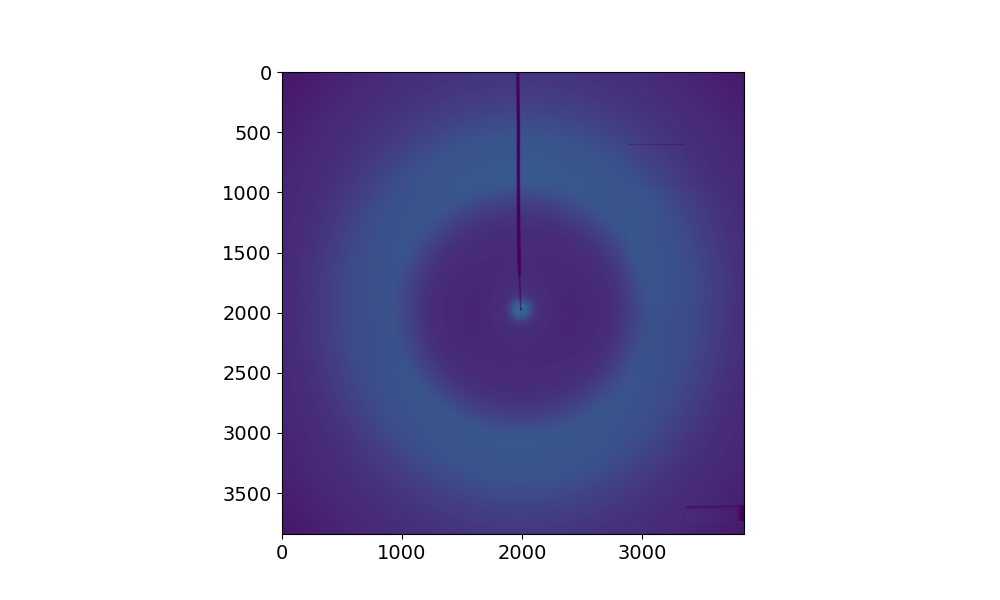

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6));
ax.imshow(pic.data)

#### Reduce a scan

`tag`: name of the folder set in `Path` in the Laue Data Collection software.  
The Laue _File Basename_ should be the same, and the _Log file_ should be `tag`.log

In Laue, You set the number of images to take per time step on the 2nd pane _options_ 

In Lause, _Time delays_ are set in ps,ns,us, negative delays are off, put the chosen off time into `APS(off_time=)`. We've used -3us and -3ns in the past.

In [119]:
tag = 'Dye2CHheatscan_370'  
aps = APS(energy=12, path=f'/net/helix/data/levi_2209/{tag}/', 
              tag=tag, off_time=-3e-6)
aps.get_delays()  # get delays for each img from log file
aps.set_mask('../levi/on-mask_strickt.edf')  # set the mask used by pyFAI. 
q, s, sigmas = aps.reduce(n_imgs='all')  # reduce img. 'all' or first 'n' images
all_ds = aps.calc_ds(nearest_off_neighbours=2)  # calculate dS, using weighed avg of the 2 nearest off images
aps.save() # save in path/../reduced/

# detector distance: 363.0 mm

Reducing


  4%|███▋                                                                                   | 15/350 [00:11<04:24,  1.27it/s]


Due to fluctuations on the beamline, on/off subtraction seems to give the strongest signal if there is no more than 3-4 s between an on image and its nearest of images, so for a 1s exposure time, you can run `off,on,on,on`. 

If you have larger exposure times (Levi2022 ended on 2s), you might need to just use the single closest off image instead of making a weighed avg, so 
`nearest_off_neighbours=1`

Often you want to reduce a scan that is still running, but you don't want to re-reduce the already reduced files. Then you can:

In [4]:
aps = np.load(f'/net/helix/data/levi_2209/reduced/{tag}.npy', allow_pickle=True).item()  # load the just saved aps
print(tag)
aps.parse_log()  # re-read the log
aps.get_delays() # get new delays from parsed log
aps.set_mask('../levi/on-mask_strickt.edf')
q, s, sigmas = aps.reduce(n_imgs='all')  # reduce new images

Dye2CHheatscan_370
# detector distance: 186.0 mm

Reducing


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [03:44<00:00,  3.25it/s]


Plot all time delays:

Delay: -3.00e-06 #imgs: 183
Delay:  2.00e-10 #imgs: 183
Delay:  4.00e-10 #imgs: 183
Delay:  1.00e-09 #imgs: 182


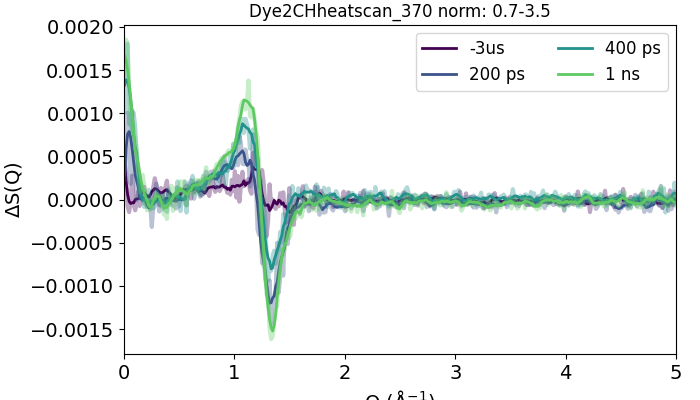

In [5]:
aps.norm_range = [0.7, 3.5]   # maybe you want to play around with the q range in which on/off curves are scaled
all_ds = aps.calc_ds(nearest_off_neighbours=2)  # or how many   
aps.save()  # save again
fig, ax = plot_curves(aps, sgf=11)  # sgf: smoothnes of savgol filter on top of raw curves
fig.set_size_inches([7, 4])  
_, _ = aps.count_imgs()  # print how many images per time step used. 

## Alignment scans

**Motors:**

**Gon** (capillary):
1. **Y**: vertical cap position. _smaller_ number means _lower_ cap which means xrays closer to _top_ edge, where the laser comes in
2. **Z**: Along the capillary itself. Can be useful if you make spots on the cap, and you want to avoid burning holes in it
3. **X**: Along the x-ray directions, not really scanned apart from at the very start, unless you change cap.

**Laser** :
1. **X**: Across the cap along the x-ray direction, important for overlap
2. **Y**: Along the laser beam so, 'up and down', i.e. focusing. Not something users touch often if at all
3. **Z**: Horizontal along the capillary. Important for xray/laser overlap


The best/fastest procedue is something as follows:
1. Quickly find the middle of the cap (e.g. 700um) in GonY by taking 0.2 mm stepsand pressing _single image_ in Laue Collect to see when the liquid ring dissapears and we only have glass/air scattering. 
2. Go to center, so e.g. you're at the top edge, go down (positive direction) ~350um
3. Scan laserx in 10-20 um steps, find maximum signal at e.g. 100ns, using ~20 imgs at 2s exposure (or 40 at 1s)
2. Scan gonY upwards (negative) at e.g. 100um or 50um stes, find best signal, _without_ xrays starting to hit cap wall. 

##### Summing up the results of such a gony scan could look like this:

Dye2CHheatscan_350, images:  20, Signal Strength: 0.050423258178056055
Dye2CHheatscan_351, images:  30, Signal Strength: 0.041286567336787865
Dye2CHheatscan_353, images:  28, Signal Strength: 0.06381523701500917
Dye2CHheatscan_354, images:  20, Signal Strength: 0.05953173478997733


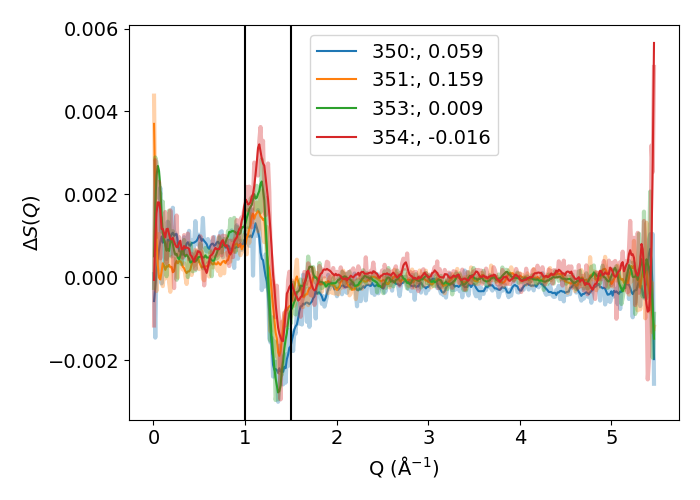

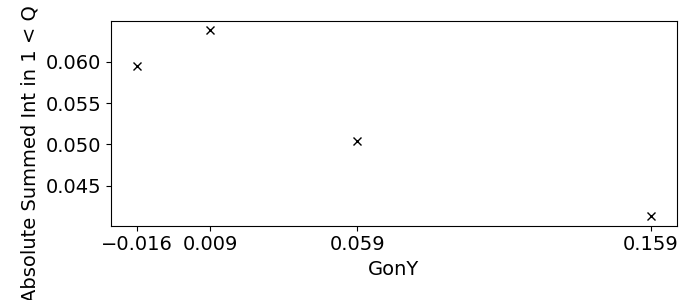

In [17]:
scandict = {350:0.059, 351:0.159, 352:0.109, 353:0.009, 354:-0.016}
tmp = np.array([(key, val) for key, val in scandict.items() if key not in [352]])
scanlist = tmp[:, 0]
mopolist = tmp[:, 1]

apslist = []
for scan in scanlist:
    tag = f'Dye2CHheatscan_{int(scan):03d}'
    aps_tmp = np.load(f'/net/helix/data/levi_2209/reduced/{tag}.npy', allow_pickle=True).item()
    aps_tmp.norm_range = [0.69, 3.6]
    apslist.append(aps_tmp)

fig, ax = plot_motor(apslist, mopolist, delay=100e-9, qrange=[1, 1.50], xlabel='GonY', sgf=11)
fig.set_size_inches([7, 3])  
fig.tight_layout()

looks like 0.009 is the best place to be. 

Assuming you've done all the other alignment, you should do a laser power titration at least once before starting to measure. 

### Power titration

Basically just like any other "motor" scan. After a bunch of reductions of "scans" at different laser powers you:

overlapScan_106, images:  30, Signal Strength: 0.16901142535247968
overlapScan_107, images:  30, Signal Strength: 0.1090160161923573
overlapScan_108, images:  29, Signal Strength: 0.08656140575561776
overlapScan_109, images:  24, Signal Strength: 0.06628872818363571
overlapScan_110, images:  30, Signal Strength: 0.06152000036056207
overlapScan_111, images:  30, Signal Strength: 0.029964960800857164
overlapScan_112, images:  30, Signal Strength: 0.12610483837236644
overlapScan_113, images:  30, Signal Strength: 0.14655807247484284
overlapScan_114, images:  15, Signal Strength: 0.09863473601957402


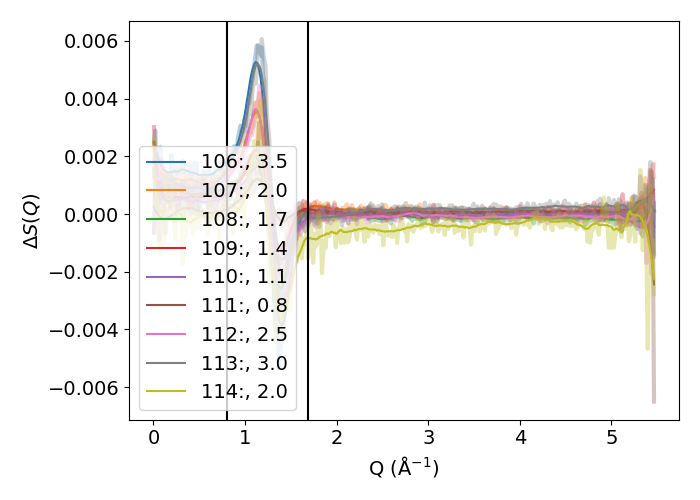

In [20]:
mopolist = np.array([3.5, 2.0, 1.7, 1.4, 1.1, 0.8, 2.5, 3.0, 2.0])
scanlist = np.array([106, 107, 108, 109, 110, 111, 112, 113, 114])

apslist = []
for scan in scanlist:
    tag = f'overlapScan_{scan:03d}'
    aps_tmp = np.load(f'/net/helix/data/levi_2209/reduced/{tag}.npy', allow_pickle=True).item()
    aps_tmp.norm_range = [0.7, 3]
    apslist.append(aps_tmp)
    
fig, ax = plot_motor(apslist, mopo=mopolist, delay=1e-6, qrange=[0.8, 1.69], 
                     xlabel='LaserPower', do_fit=True)


Seems pretty linear over the entire laser power range.. But don't go crazy! :D 


Ok time to measure! After that you probably want to 

#### Stack scans, test noise

In [45]:
delays = [-3e-06, 2e-10, 4e-10, 1e-09]  # which delays to include in the new stack
scans = np.array([125, 172, 173, 186] + list(range(363, 371)))  # which scans to stack
exclude_scans = []  # if you have a long list but 1 bad scan in the middle... 
scans = np.array([scan for scan in scans if scan not in exclude_scans])  

aps_stacked = stack('/net/helix/data/levi_2209/reduced/', 
            delays, 
            scans, 
            norm_range=[0.7, 3.6],     # norm range for new dS
            nearest_off_neighbours=2)  #

tag = 'stack_'
for scan in scans:
    tag += '%d-' %(scan)
tag += 'HeatStack-oneoff'
aps_stacked.tag = tag
aps_stacked.save()  # resave it

Let's check the noise of all of our heat scans vs the desired SNR from the proposal. First we need to scale the exp signal to the simulation from the proposal, which should be in electronic units. 

This is beamtime code, so the right way to do this would be to convert everything correctly into electronic units (scale to liquid unit cell), and fit the scaler. 

Here, we _estimate_ things, so simply tune the `rough_scaler` until the two curves are kinda on top of each other.. 

In [48]:
# get q and the median dS from all dS curves
q = aps_stacked.q

# Stacking all time delays
ds_exp = np.median(np.concatenate([aps_stacked.all_ds[delay] for delay in delays]), 0)

# If you want to rebin in q, rebin q and ds_exp here

# load the simulated heat signal, which has the correct ratio solute:solvent
sim_heat = np.genfromtxt('sim_signals/ch_dsdt_smooth.txt')

rough_scaler = 460  # dirty find the scaler to scale our experiment heat to the simulated heat amplitude
shift_q = 0.97  # All online reductions happened at 12keV, we have something closer to 11.6 keV.. 

# lets see how we did
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(q * shift_q, ds_exp * rough_scaler, label='Scaled Experiment')
ax.plot(sim_heat[:, 0], sim_heat[:, 1], label='Simulation')
ax.legend(loc='best', fontsize=12)
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('$\Delta S(Q)$')


Text(0, 0.5, '$\\Delta S(Q)$')

And then use the noise estimator on the simulated noisy signal vs the actual, scaled experimental signal:

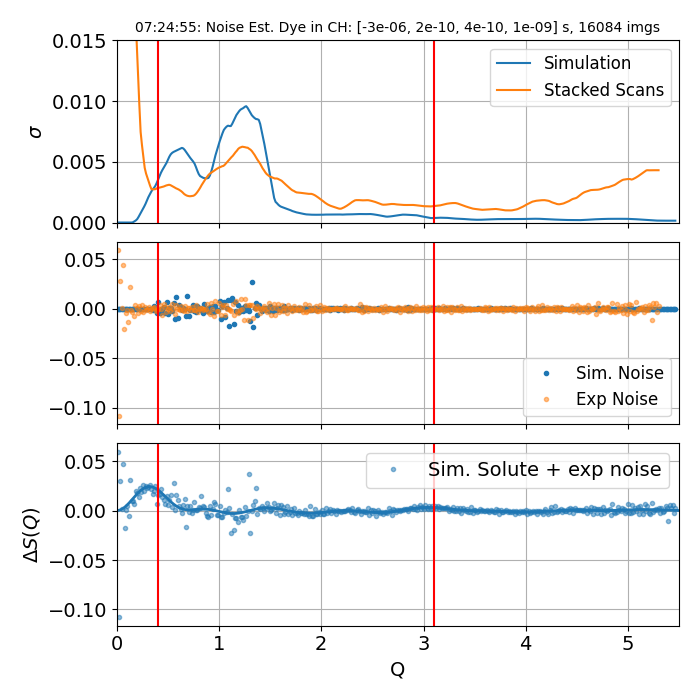

In [53]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

# estimate the noise on the newly recorded heat, using the dirty scaling
exp_sigma, noise = estimate_noise_per_q(rough_scaler * ds_exp, 0.5, num_intervals=20)  # estimate noise

sim = np.genfromtxt('sim_signals/ds_aps_2880_960min.dat')  # load solute curves
# sim[:, 1] is simulated solute
# sim[:, 2] is simulated solute + simulated noise
# sim[:, 2] is simulated noise

# interp to exp Q within the exp Q limits
qmin = min(q)
qmax = max(q)
sim_in_exp_q = np.interp(q[(q >= qmin) & (q <= qmax)], 
                         sim[(sim[:, 0] >= qmin) & (sim[:, 0] <= qmax), 0], 
                         sim[(sim[:, 0] >= qmin) & (sim[:, 0] <= qmax), 2])

# estimate "simulation noise" with the same params as we did for exp
sim_sigma, sim_noise = estimate_noise_per_q(sim_in_exp_q, 0.5, num_intervals=20)

#plot the variance of both sim and exp
fig, axes = plt.subplots(3, 1, figsize=(7, 7))
ax = axes[0]
ax.plot(q, sim_sigma, label='Simulation')
ax.plot(q * shift_q, exp_sigma, label='Stacked Scans')
ax.legend(loc='upper right', fontsize=12)
ax.set_xticklabels([])
ax.set_ylabel('$\sigma$')
num_imgs = 0
for delay in delays:
    num_imgs += aps_stacked.all_ds[delay].shape[0]
ax.set_title(f'{current_time}: Noise Est. Dye in CH: {delays} s, {num_imgs} imgs', fontsize=10)
ax.set_ylim([0, 0.015])

# plot the extracted noise of both
ax = axes[1]
ax.plot(q, sim_noise, '.', alpha=1, label='Sim. Noise')
ax.plot(q* shift_q, noise, '.', alpha=.5, label='Exp Noise')
ax.legend(loc='best', fontsize=12)

ax.set_xticklabels([])
#
ax = axes[2]
ax.plot(sim[:, 0], sim[:, 1], lw=2)
ax.plot(q, sim_in_exp_q + noise, 'C0.', alpha=0.5, label='Sim. Solute + exp noise')
ax.set_xlim([0, 4.5])
ax.legend(loc='upper right')

ax.set_xlabel('Q')
ax.set_ylabel('$\Delta S(Q)$')
# make it pretty
for ax in axes:
    ax.grid()
    ax.set_xlim([0, 5.5])
    ax.axvline(0.4, color='r')
    ax.axvline(3.1, color='r')

fig.tight_layout(h_pad=0.4)

This is good enough for beamtime work, but in the end you'd like to **filter** your curves on e.g. the summed intensity of the absolute curves (not dS) before calculating dS. The version from last beamtime doesn't work too well on this data + we need to be more careful removing _sets_ of (off,on,on,on) in order to not cause the final dataset to have too large holes beetween off shots.

You should most likely also look at the slow time evolution of your curves through the stacks, as there has been low-q buildup in some of the scans, we had air scattering issues at some point, general chaos.. :D 

See e.g. the HTI stack:

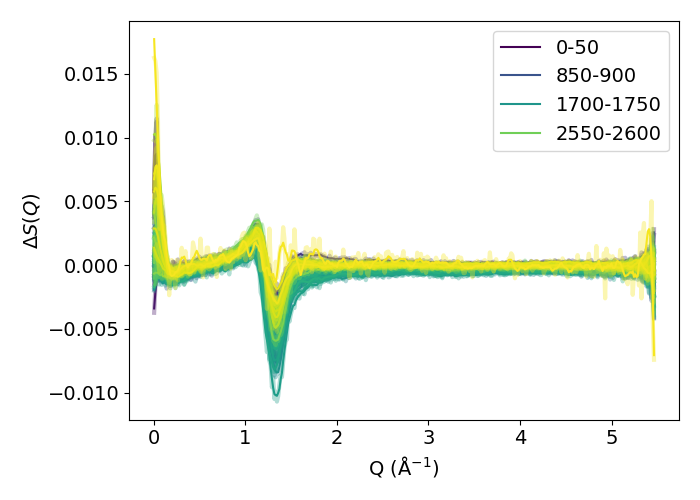

In [68]:
from aps.stacking import stack

delays = [-3e-06, 2e-10, 4e-10, 1e-09]
scans = np.arange(284, 331)
exclude_scans = [289, 291, 292, 297, 316, 317, 318, 320, 329]
scans = np.array([scan for scan in scans if scan not in exclude_scans])

aps_stacked = stack('/net/helix/data/levi_2209/reduced/', 
            delays, 
            scans, 
            norm_range=[0.7, 3.5])

tag = 'stack_'
for scan in scans:
    tag += '%d-' %(scan)
tag += 'nolong'
aps_stacked.tag = tag

#aps.save()  # resave it
q = aps_stacked.q


binsize = 50
fig, ax, binned_ds = plot_img_chunks(aps_stacked, 400e-12, bin_imgs=binsize, legend_entries=4, return_bins=True)

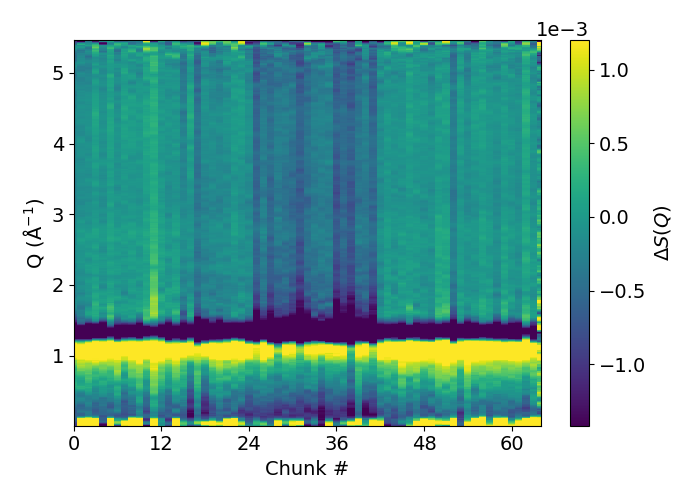

In [69]:
from collections import OrderedDict
import scipy.stats as ss

q_limits = [min(aps_stacked.q), max(aps_stacked.q)]
smooth = 10
contrast = 15


bins = np.arange(len(binned_ds))
od = OrderedDict({this_bin:ds for this_bin, ds in zip(bins, binned_ds)})

times = np.array([key for key in od.keys()])
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()
ts, qs = np.meshgrid(times, aps_stacked.q)
diffs = np.concatenate([sg(value, smooth, 3)
                            for value in od.values()]).reshape(len(times), len(aps_stacked.q))

plt.pcolormesh(ts, qs, diffs.T, shading='auto')


ax.set_xticks(times[::12])


ax.set_xlim(min([t for t in times if t != aps_stacked.off_time]),
            max([t for t in times if t != aps_stacked.off_time]))
cbar = plt.colorbar()
limit_m = 100 / contrast
qq = list(range(len(aps_stacked.q)))
mad = ss.median_abs_deviation
clims = [np.median(diffs[:, qq]) - limit_m * mad(diffs[:, qq], axis=None),
         np.median(diffs[:, qq]) + limit_m * mad(diffs[:, qq], axis=None)]


plt.clim(clims)
if q_limits is None:
    q_limits = [min(aps_stacked.q), max(aps_stacked.q)]
ax.set_ylim(q_limits)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label('$\Delta S(Q)$')
ax.set_ylabel('Q (Å$^{-1}$)')
ax.set_xlabel('Chunk #')
fig.tight_layout()


Previously, we saw more periodicity, which is.. not there now.. 

In any case it might be important to investigate this, try to do the calc_ds() when filtering out the shots in between chunk ~24-40 or so.. Or try to normalize them differently. 

You could also check to slow-time drift components by SVD'ing this. 

You basically need to end up with something that is smooth across the x-axis, the smoother it is, the stronger your signal, and the better your SNR.

# Examples from earlier beamtime(s)

This time we had more time points, so 2d scans make sense. 

In [13]:
aps = np.load('../DATA/reduced/Ru_MeOH_1_072.npy', allow_pickle=True).item()

In [192]:
fig, ax, = plot_2d(aps, q_limits=[0, 0.7], contrast=5, smooth=5);